# Comparing All Optimization Results

In [1]:
import math
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import plotly.express as px
import networkx as nx
import warnings
import geopandas as gpd
from shapely.geometry import Point, LineString
from matplotlib.colors import ListedColormap
from shapely.geometry import MultiPoint
import matplotlib.image as mpimg

%run data_cleaning.ipynb
%run optimization_functions.ipynb

### Import all necessary data

In [2]:
centroid_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_NS.csv")
census_data = data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08119_stl_city.csv")
race_data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08105_stl_city.csv")
stl = nx.read_weighted_edgelist(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\weighted_dual_list",delimiter='%',nodetype=str)

### Clean the data and set constants

In [3]:
k = 12 #number of clusters/metro stops for all algorithms
by_tract = clean(census_data, race_data)
centroid_locations_small = centroid_locations[['NAMELSAD','INTPTLAT','INTPTLON']]
centroid_locations_small = centroid_locations_small.rename(columns = {"NAMELSAD": "location", "INTPTLAT" : "LAT", "INTPTLON" : "LON"})
full_data = by_tract.merge(centroid_locations_small, on='location')
full_data.head()

,location,estimate,transit weight,transit weight (pop),income weight,income weight (pop),race weight,race weight (pop),node id,LAT,LON
0,Census Tract 1011,1039,0.003275,0.434255,0.009653,1.280070,0.007499,0.994323,1011,38.554718,-90.273620
1,Census Tract 1012,1921,0.001162,0.091845,0.009570,0.756349,0.012480,0.986410,1012,38.561824,-90.274863
2,Census Tract 1013,2161,0.003697,0.259777,0.009560,0.671698,0.013909,0.977253,1013,38.566560,-90.264211
3,Census Tract 1014,1502,0.010036,1.014476,0.009614,0.971790,0.010099,1.020846,1014,38.562243,-90.253522
4,Census Tract 1015,1318,0.003381,0.389424,0.009645,1.111024,0.008554,0.985409,1015,38.548544,-90.264511


### K-Means

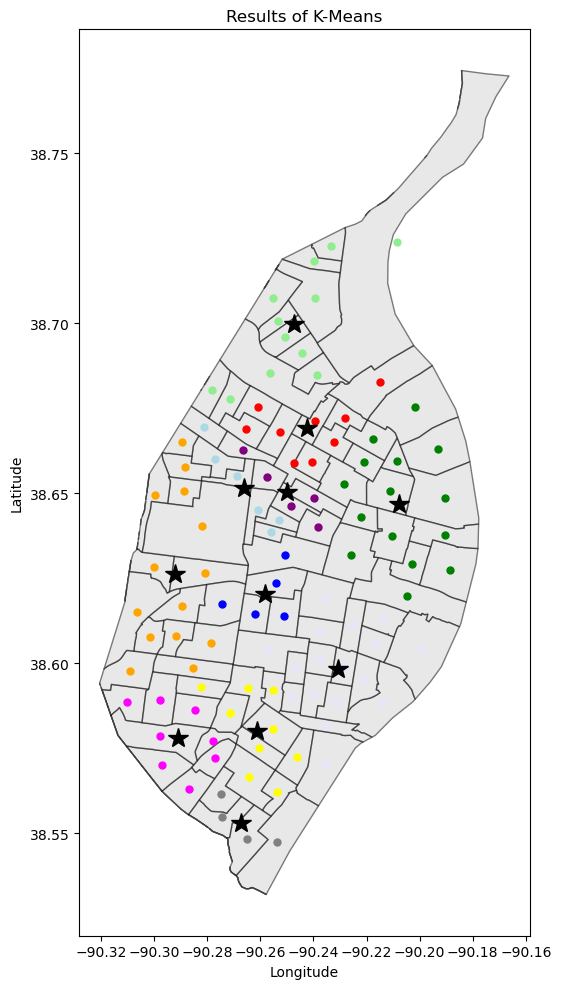

In [4]:
k_means_weight = 'race weight'
k_means_stops, labels = weighted_kmeans(full_data, k, k_means_weight)

cluster_dict = {k:v for k, v in zip(full_data['node id'],labels)}
k_means_graph = stl.copy()
nx.set_node_attributes(k_means_graph, cluster_dict, 'cluster')
nx.write_gexf(k_means_graph, "capstone.gexf")
_ = graph_results(k_means_graph, 'K-Means')

### Linear Programming

In [5]:
lp_stops = linear_programming(full_data)

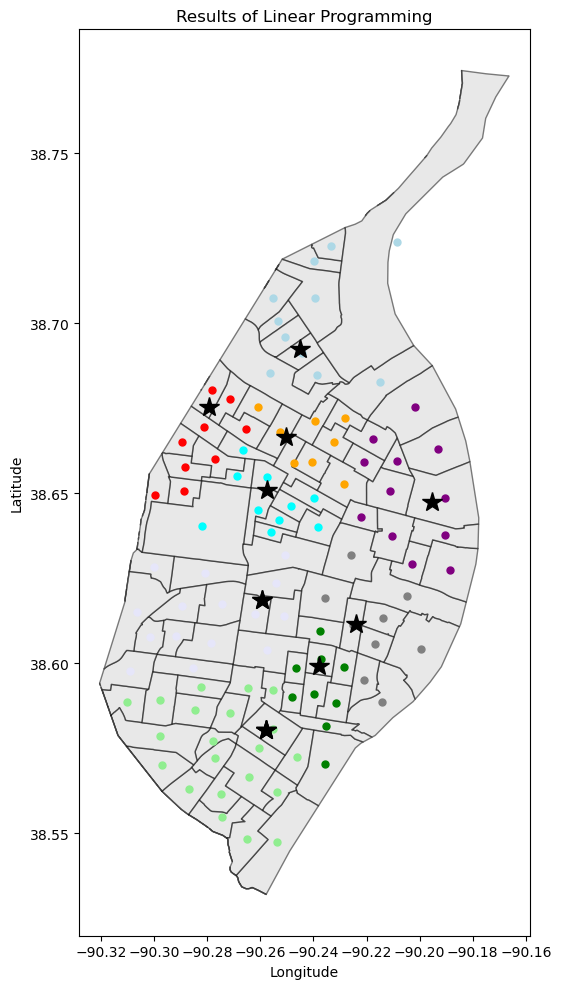

In [6]:
labels = graph_from_lp(full_data, lp_stops)
cluster_dict = {k:v for k, v in zip(full_data['node id'],labels)}
lp_graph = stl.copy()
nx.set_node_attributes(lp_graph, cluster_dict, 'cluster')
nx.write_gexf(lp_graph, "capstone.gexf")
graph_results_lp(lp_graph, lp_stops, 'Linear Programming')

### Modularity Maximization

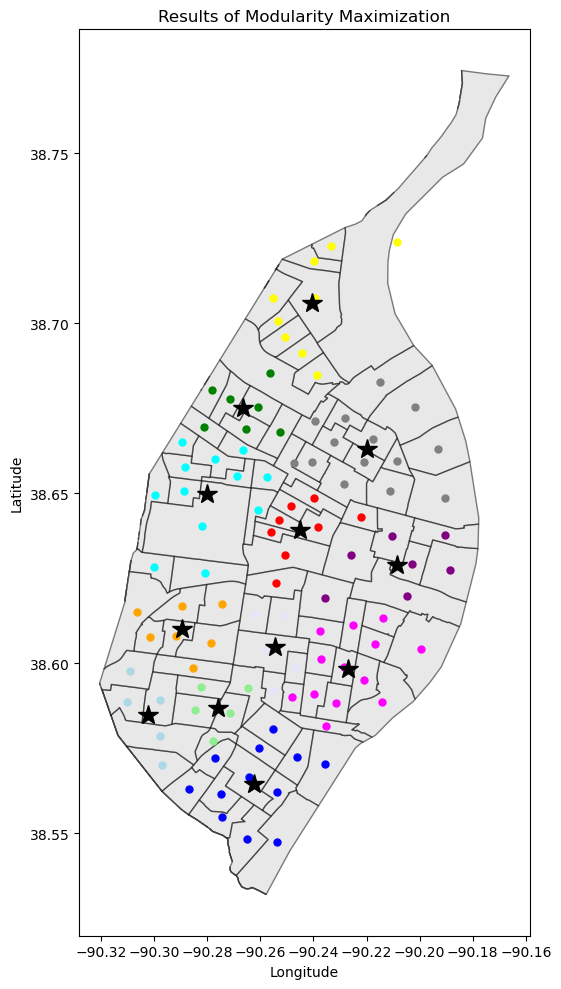

In [7]:
mod_max = mod_max_weighted(stl,k)

nx.write_gexf(mod_max, "capstone.gexf")
mm_stops = graph_results(mod_max, 'Modularity Maximization')

# Evaluating Methods Against One Another

In [8]:
total_lp_dist = dist_to_nearest_stop_eval(full_data, lp_stops)
lp_unweighted_eval = np.mean(total_lp_dist)
lp_race_eval = np.dot(full_data['race weight'], total_lp_dist)
lp_income_eval = np.dot(full_data['income weight'], total_lp_dist)
lp_transit_eval = np.dot(full_data['transit weight'], total_lp_dist)
print(f'LP unweighted eval: {lp_unweighted_eval}')
print(f'LP race eval: {lp_race_eval}')
print(f'LP income eval: {lp_income_eval}')
print(f'LP transit eval: {lp_transit_eval}\n')


total_km_dist = dist_to_nearest_stop_eval(full_data, k_means_stops)
km_unweighted_eval = np.mean(total_km_dist)
km_race_eval = np.dot(full_data['race weight'], total_km_dist)
km_income_eval = np.dot(full_data['income weight'], total_km_dist)
km_transit_eval = np.dot(full_data['transit weight'], total_km_dist)
print(f'K-Means unweighted eval: {km_unweighted_eval}')
print(f'K-Means race eval: {km_race_eval}')
print(f'K-Means income eval: {km_income_eval}')
print(f'K-Means transit eval: {km_transit_eval}\n')

total_mm_dist = dist_to_nearest_stop_eval(full_data, mm_stops)
mm_unweighted_eval = np.mean(total_km_dist)
mm_race_eval = np.dot(full_data['race weight'], total_mm_dist)
mm_income_eval = np.dot(full_data['income weight'], total_mm_dist)
mm_transit_eval = np.dot(full_data['transit weight'], total_mm_dist)
print(f'Mod Max unweighted eval: {mm_unweighted_eval}')
print(f'Mod Max race eval: {mm_race_eval}')
print(f'Mod Max income eval: {mm_income_eval}')
print(f'Mod Max transit eval: {mm_transit_eval}\n')

LP unweighted eval: 1.2120468999075675
LP race eval: 1.2791353118162796
LP income eval: 1.2111607780358267
LP transit eval: 1.09061970758053

K-Means unweighted eval: 0.9593492228861702
K-Means race eval: 0.9061578853263662
K-Means income eval: 0.9599719419638588
K-Means transit eval: 0.9958795770735666

Mod Max unweighted eval: 0.9593492228861702
Mod Max race eval: 0.800082468776742
Mod Max income eval: 0.8327031266853556
Mod Max transit eval: 0.8320310647951292



## Graphs for Evaluation

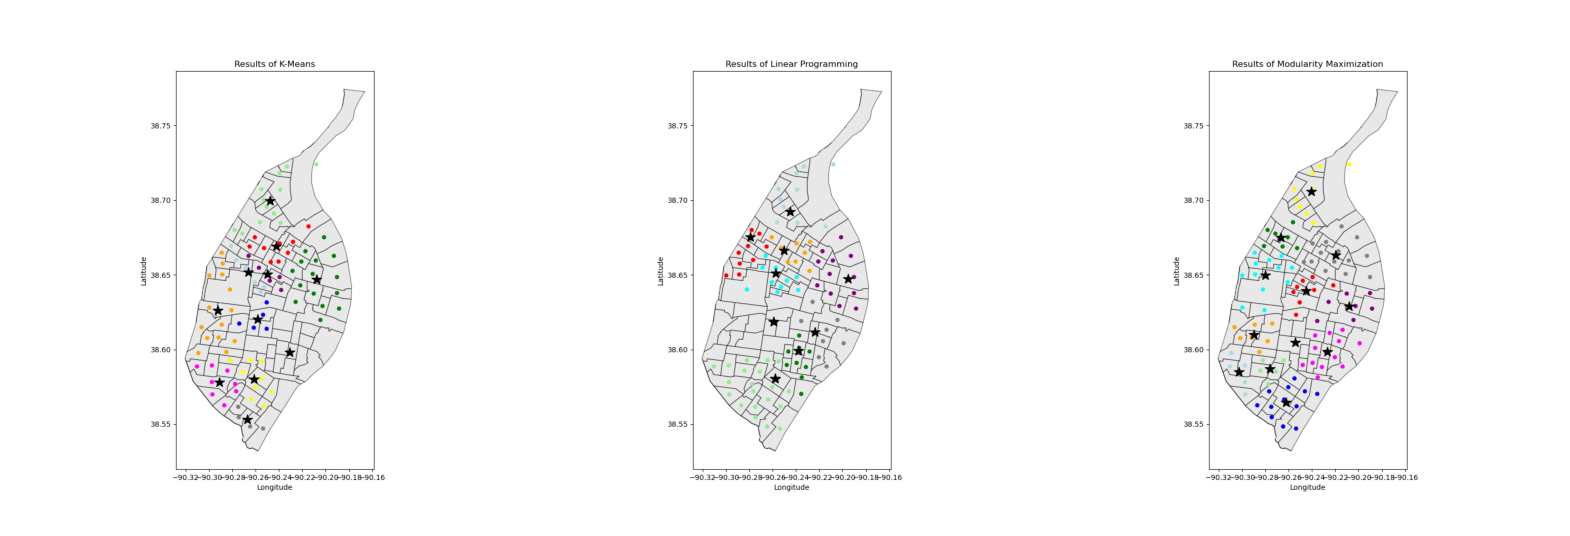

In [23]:
lp = mpimg.imread('K-Means.png')
km = mpimg.imread('Linear Programming.png')
mm = mpimg.imread('Modularity Maximization.png')

plt.figure(figsize=(20, 15)) 
plt.subplots_adjust(wspace=0)
plt.subplot(1, 3, 1) 
plt.imshow(lp)
plt.axis('off')
plt.subplot(1, 3, 2) 
plt.imshow(km)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mm)
plt.axis('off')
plt.show()